# Práctica análisis de redes sociales y algortimos genéticos y evolutivos. Amazon dataset
## Adrián Gayo e Iñaki del campo.

### Importamos las librerías necesarias

In [2]:
#!pip install python-louvain
#!pip install wurlitzer bayanpy infomap pyclustering ASLPAw
#!pip install pymoo
#!pip install deap


In [3]:
import networkx as nx
import os
import matplotlib.pyplot as plt
from cdlib.algorithms import leiden
from sklearn.metrics import normalized_mutual_info_score
from sklearn import preprocessing
from collections import Counter
import pandas as pd
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.optimize import minimize
from deap import base, creator, tools, algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


## Estructura de comunidad con Leiden

### Cargamos el grafo desde archivo y lo visualizamos

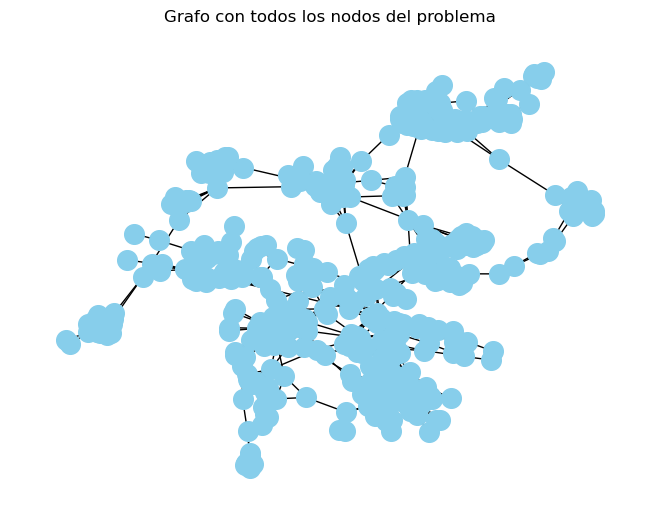

In [4]:

# Ruta donde se almacena el archivo que contiene el grafo.
archivo_graphml = 'amazon_graph/amazon_graph.graphml'

ruta_grafo =  os.path.abspath(archivo_graphml)

# Cargar el grafo desde el archivo GraphML
G = nx.read_graphml(ruta_grafo)

# Ahora visualizamos el contenido del grafo que hemos cargado.

pos = nx.spring_layout(G)  # Probar distintos layouts
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, node_color='skyblue', font_size=8)
plt.title("Grafo con todos los nodos del problema")
# Mostrar el gráfico
plt.show()


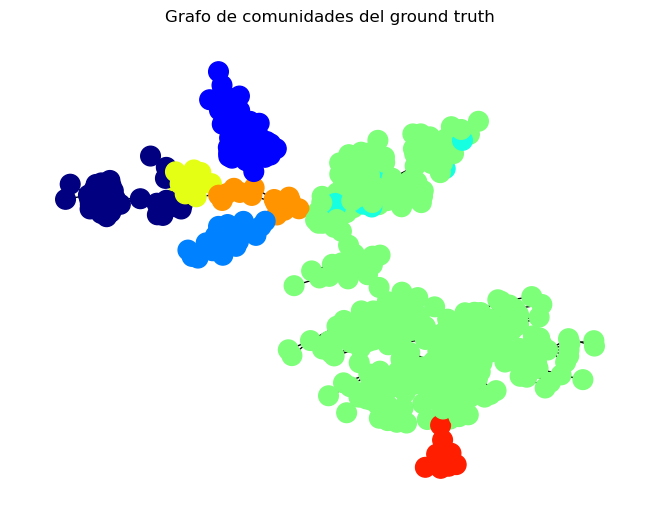

In [5]:
# Ahora lo visualizamos teniendo en cuenta las comunidades
comunidades_reales = nx.get_node_attributes(G, 'community')

# Crear un diccionario de colores para cada comunidad
colores_comunidades = {}
for comunidad in set(comunidades_reales.values()):
    colores_comunidades[comunidad] = plt.cm.jet(comunidad / len(set(comunidades_reales.values())))

# Asignar colores a los nodos según su comunidad
colores_nodos = [colores_comunidades[comunidades_reales[nodo]] for nodo in G.nodes]

# Probar distintos layouts
pos = nx.kamada_kawai_layout(G)

# Dibujar el grafo con colores de comunidades
nx.draw(G, pos, with_labels=False, node_size=200, node_color=colores_nodos, font_size=8)

plt.title("Grafo de comunidades del ground truth")

# Mostrar el gráfico
plt.show()

### Calculamos métricas del ground truth

In [6]:
# Calcula la densidad del grafo
density = nx.density(G)

# Obtenemos los datos originales de los nodos con la comunidad a la que pertenece en realidad.
lista_nodos = [(int(nodo), int(atributos['community'])) for nodo, atributos in G.nodes(data=True) if 'community' in atributos]

# Comprobamos la modularidad de la solución real.
partition_real = [set() for _ in range(max(comunidad for _, comunidad in lista_nodos) + 1)]
for nodo, comunidad in lista_nodos:
    partition_real[comunidad].add(str(nodo))

# Calcular la modularidad con la partición real
q_real = nx.community.modularity(G, partition_real)

print(f"Densidad del grafo: {density}")
print(f"\nModularidad con partición real: {q_real :.4f}")

Densidad del grafo: 0.010517432822562735

Modularidad con partición real: 0.5748


### Detectamos las comunidades con el algoritmo de Leiden

defaultdict(<class 'list'>, {'176159': [0], '401449': [0], '321619': [0], '432229': [0], '59613': [0], '430314': [0], '30962': [0], '35067': [0], '217346': [0], '295177': [0], '190765': [0], '198973': [0], '141635': [0], '258382': [0], '108892': [0], '475666': [0], '326211': [0], '504412': [0], '539292': [0], '109222': [0], '51902': [0], '150207': [0], '428737': [0], '447224': [0], '500473': [0], '365309': [0], '365354': [0], '295752': [0], '265066': [0], '285549': [0], '127928': [0], '310236': [0], '373756': [0], '211967': [0], '336905': [0], '19509': [0], '199759': [0], '74895': [0], '484561': [0], '392463': [0], '279830': [0], '423198': [0], '197919': [0], '230788': [0], '236947': [0], '46508': [0], '380338': [0], '112056': [0], '404948': [0], '179698': [0], '187924': [0], '310851': [0], '470620': [0], '452208': [0], '122517': [0], '313006': [0], '108259': [0], '268123': [0], '317367': [0], '448649': [1], '172218': [1], '250046': [1], '497867': [1], '350442': [1], '14686': [1], '597

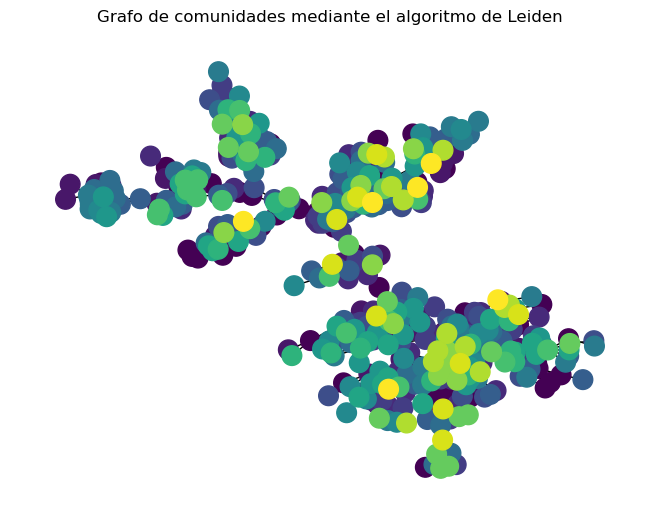

In [7]:
leiden_coms = leiden(G).to_node_community_map()
print(leiden_coms)

coms = {k:v[0] for k,v in leiden_coms.items()}

# Crear un diccionario que asigna colores únicos a cada comunidad
colores_comunidades = {comunidad: idx for idx, comunidad in enumerate(set(coms.values()))}

# Obtener colores para cada nodo según su comunidad
colores_nodos = [colores_comunidades[comunidad] for comunidad in coms.values()]

print(colores_nodos)

# Visualizar el grafo con las comunidades coloreadas
#pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)  # Utilizamos kamada_kawai_layout para organizar los nodos de manera estructurada
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)

plt.title("Grafo de comunidades mediante el algoritmo de Leiden")
# Mostrar el gráfico
plt.show()

Probamos con diferentes formas de grafo

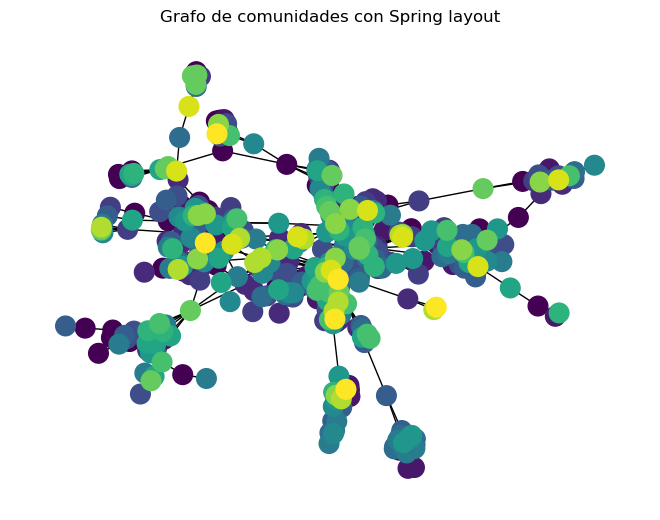

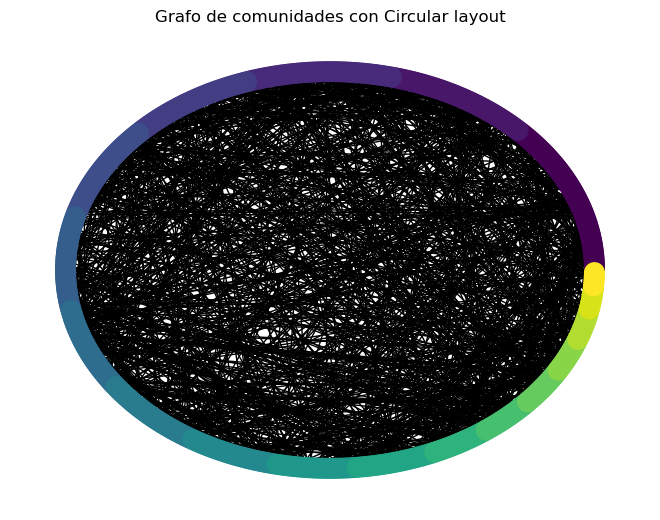

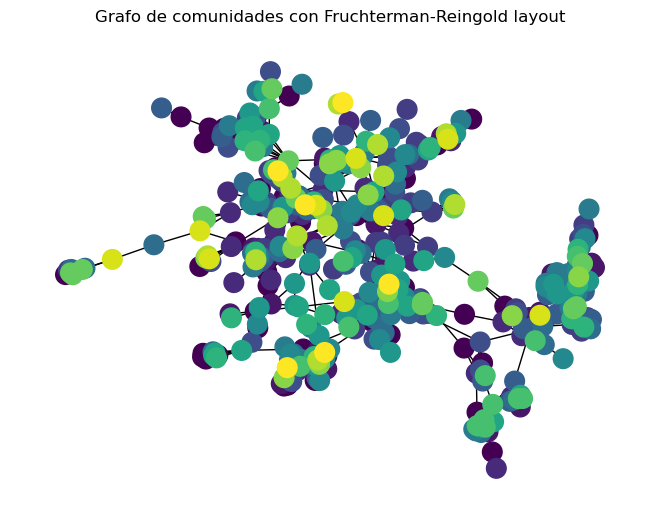

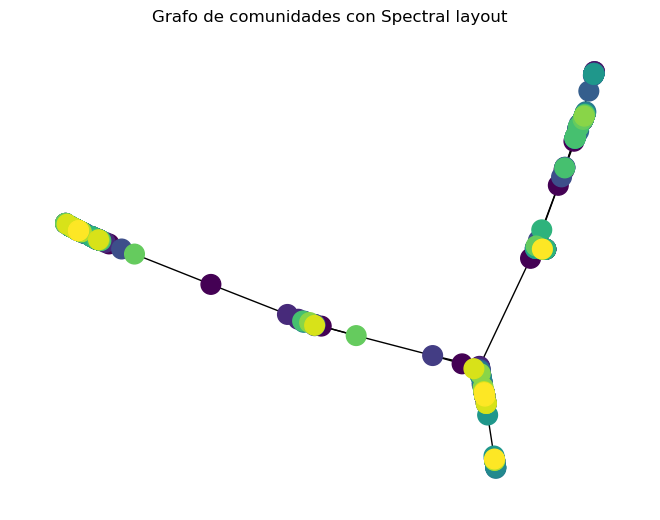

In [8]:
#Spring layout
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Spring layout")
plt.show()

#Circular layout
pos = nx.circular_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Circular layout")
plt.show()

#Fruchterman-Reingold layout
pos = nx.fruchterman_reingold_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Fruchterman-Reingold layout")
plt.show()

#Spectral layout
pos = nx.spectral_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Spectral layout")
plt.show()

### Obtenemos la frecuencia de cada comunidad

In [9]:
#Contar la frecuencia de cada valor en el diccionario
frecuencia_coms = Counter(coms.values())

# Convertir el diccionario de frecuencias a un DataFrame de pandas
df_frecuencias = pd.DataFrame(frecuencia_coms.items(), columns=['Comunidad', 'Frecuencia'])

# Imprimir el DataFrame sin el índice
print(df_frecuencias.to_string(index=False))

 Comunidad  Frecuencia
         0          59
         1          42
         2          42
         3          37
         4          37
         5          36
         6          32
         7          30
         8          26
         9          23
        10          23
        11          17
        12          16
        13          15
        14          13
        15          12
        16           9
        17           6


### Calculamos la modularidad

In [10]:
print(coms)

# Convertir el diccionario coms en una lista de conjuntos
partition = [set() for _ in range(max(coms.values()) + 1)]
for nodo, comunidad_id in coms.items():
    partition[comunidad_id].add(nodo)
    
print(partition)
    
q =  nx.community.modularity(G, partition)

print(f"\nModularidad del algoritmo de Leiden: {q :.4f}")

{'176159': 0, '401449': 0, '321619': 0, '432229': 0, '59613': 0, '430314': 0, '30962': 0, '35067': 0, '217346': 0, '295177': 0, '190765': 0, '198973': 0, '141635': 0, '258382': 0, '108892': 0, '475666': 0, '326211': 0, '504412': 0, '539292': 0, '109222': 0, '51902': 0, '150207': 0, '428737': 0, '447224': 0, '500473': 0, '365309': 0, '365354': 0, '295752': 0, '265066': 0, '285549': 0, '127928': 0, '310236': 0, '373756': 0, '211967': 0, '336905': 0, '19509': 0, '199759': 0, '74895': 0, '484561': 0, '392463': 0, '279830': 0, '423198': 0, '197919': 0, '230788': 0, '236947': 0, '46508': 0, '380338': 0, '112056': 0, '404948': 0, '179698': 0, '187924': 0, '310851': 0, '470620': 0, '452208': 0, '122517': 0, '313006': 0, '108259': 0, '268123': 0, '317367': 0, '448649': 1, '172218': 1, '250046': 1, '497867': 1, '350442': 1, '14686': 1, '59759': 1, '153979': 1, '186827': 1, '80379': 1, '203272': 1, '363079': 1, '440989': 1, '99026': 1, '84693': 1, '111376': 1, '181025': 1, '244578': 1, '205676': 

### Calculamos el NMI

In [11]:
# Calcular el NMI
ground_truth_labels = list(comunidades_reales.values())
predicted_labels = list(coms.values())

# Normalizar las etiquetas para asegurar que tengan el mismo rango
ground_truth_labels = preprocessing.LabelEncoder().fit_transform(ground_truth_labels)
predicted_labels = preprocessing.LabelEncoder().fit_transform(predicted_labels)

nmi_score = normalized_mutual_info_score(ground_truth_labels, predicted_labels)

print(f"NMI Score: {nmi_score}")

NMI Score: 0.09360071816178217


### Comparamos los resultados obtenidos con los reales

In [12]:

# Ordenamos la lista para poder comparar las dos más fácilmente.
lista_nodos.sort() # No es necesario para fusionarlo, pero así generamos el df ordenado.

print("lista de nodos y comunidades:\n")
print(lista_nodos)

# Modificamos y ordenamos la lista de Leiden para que coincidan ambas listas.
lista_leiden = [(int(nodo), int(atributos[0])) for nodo, atributos in leiden_coms.items()] 
lista_leiden

# Crear DataFrames a partir de las listas
df_real = pd.DataFrame(lista_nodos, columns=['Nodo', 'Comunidad_Real'])
df_leiden = pd.DataFrame(lista_leiden, columns=['Nodo', 'Comunidad_Leiden'])

# Fusionar los DataFrames en función del índice (Nodo)
df_comunidades = pd.merge(df_real, df_leiden, on='Nodo')

df_comunidades


lista de nodos y comunidades:

[(278, 4), (2486, 4), (4328, 4), (5081, 0), (9526, 0), (9762, 2), (12959, 4), (14073, 1), (14076, 1), (14686, 4), (16457, 2), (16832, 0), (18041, 4), (18650, 7), (19509, 4), (19999, 4), (21786, 4), (27890, 6), (28513, 2), (29354, 4), (29586, 4), (30093, 4), (30398, 4), (30688, 4), (30690, 4), (30962, 4), (33191, 1), (33251, 4), (33710, 4), (34895, 3), (35067, 4), (35308, 4), (38265, 3), (38671, 4), (41336, 6), (42473, 4), (43379, 4), (44908, 1), (45362, 4), (45561, 4), (46508, 4), (48131, 6), (49424, 4), (51157, 4), (51175, 2), (51902, 4), (52064, 6), (52500, 4), (52511, 4), (52785, 4), (55386, 6), (55388, 6), (57383, 6), (57600, 1), (58975, 1), (58977, 1), (59285, 4), (59532, 4), (59613, 4), (59759, 4), (59912, 4), (60211, 4), (60627, 4), (64879, 4), (67016, 4), (67572, 4), (69337, 1), (70522, 4), (71187, 4), (72915, 0), (72916, 0), (74895, 4), (75780, 4), (77701, 4), (79870, 4), (80379, 4), (80756, 4), (81228, 1), (83510, 4), (83649, 1), (83906, 4), (84

,Nodo,Comunidad_Real,Comunidad_Leiden
0,278,4,3
1,2486,4,5
2,4328,4,7
3,5081,0,10
4,9526,0,10
...,...,...,...
470,544939,2,13
471,545994,5,8
472,545995,5,8
473,546890,5,8


In [13]:
# Generamos una nueva columna que indique si el valor de ambas comunidades coincide.
df_comunidades['Coinciden'] = np.where(df_comunidades['Comunidad_Real'] == df_comunidades['Comunidad_Leiden'], True, False)

df_comunidades

,Nodo,Comunidad_Real,Comunidad_Leiden,Coinciden
0,278,4,3,False
1,2486,4,5,False
2,4328,4,7,False
3,5081,0,10,False
4,9526,0,10,False
...,...,...,...,...
470,544939,2,13,False
471,545994,5,8,False
472,545995,5,8,False
473,546890,5,8,False


In [14]:
acierto = sum(df_comunidades['Coinciden']) / len(df_comunidades)  #Esto no tiene sentido porque no tienen porque tener la misma etiqueta.

acierto

0.07157894736842105

## Algoritmo Evolutivo multiobjetivo

### Codificamos el grafo

In [15]:
# Obtiene la lista de adyacencia
adjacency_list = nx.to_dict_of_lists(G)

N = len(adjacency_list) # Número de nodos que tiene el grafo
print(f"Número de Nodos: {N}")

print("\nLista de Adyacencia:")
print(adjacency_list)
    
# Obtenemos el orden de los nodos en el grafo
node_order = list(G.nodes()) # No es necesario hacer un set, porque recibimos todos los nodos sin repeticiones.

# Crea un diccionario que mapea nodos a sus posiciones en el vector
mapeo_nodos = {nodo: indice for indice, nodo in enumerate(node_order)} # Puede que haya que crear también uno para decodificar.

# Mapea la lista de adyacencia a las posiciones en el vector
lista_adyacencia_mapeada = {mapeo_nodos[nodo]: [mapeo_nodos[adyacente] for adyacente in adyacentes] for nodo, adyacentes in adjacency_list.items()}
   
# Muestra el resultado
print("\nMapeo de Nodos a Posiciones en el Vector:")
print(mapeo_nodos)
print("\nLista de Adyacencia Mapeada:")
print(lista_adyacencia_mapeada)

# Para decodificar, invierte el diccionario de mapeo
mapeo_nodos_inverso = {indice: nodo for nodo, indice in mapeo_nodos.items()}
print("\nMapeo Inverso de Posiciones en el Vector a Nodos Originales:")
print(mapeo_nodos_inverso)
    


Número de Nodos: 475

Lista de Adyacencia:
{'75780': ['182923', '423864', '458993'], '317458': ['480479', '500861', '500865'], '186386': ['299055', '394703', '414657', '521655'], '419862': ['33251', '98081', '152407', '458993', '496201'], '176159': ['19509', '30962', '190765', '230788', '373756', '404948', '428737'], '204831': ['28513', '159972', '189286', '313801', '342330', '379184'], '104481': ['394886'], '57383': ['27890', '165463', '219781', '238491', '335987', '389895', '458993', '483076', '538129'], '401449': ['187924', '198973', '470620'], '299055': ['186386', '154202'], '176184': ['256445'], '542780': ['9762', '16457', '214555', '542319', '542899'], '366654': ['83906', '123953'], '124992': ['49424', '123681', '460073'], '16457': ['542780', '9762', '126438', '196682', '216152', '542319'], '196682': ['16457', '9762', '126438', '216152', '542319', '542899'], '546890': ['109595', '114378', '114379', '123181', '126430', '126433', '132756', '132763', '246060', '270524', '546891'], '

In [43]:
def decodificar_grafo(vector): 
    """
    Función que convierte la lista de adyacencia a grafo.
    """ 
    # Decodificamos el vecctor a una lista de adyacencia
    locus_adjacency = {i : [vecino] for i, vecino in enumerate(vector, 0)}
    
    # Crea un nuevo grafo a partir de la lista de adyacencia
    decoded_graph = nx.Graph(locus_adjacency)

    # Visualiza el nuevo grafo
    #pos = nx.spring_layout(decoded_graph)  # Layout para visualización
    #nx.draw(decoded_graph, pos, with_labels=False, font_weight='bold', node_size=200, node_color='skyblue', edge_color='gray')
    #plt.show()
    
    return decoded_graph

#decodificar_grafo(adjacency_list)

### Funciones Objetivo

En el artículo ........... nos propone una serie de funciones objetivo dentro de la detección de comunidades. La conclusión importante que nos proporciona el texto es que da mejores resultados utilizar funciones objetivo que estén negativamente correlacionadas. Esto significa que, si aumenta el valor de una de ellas, la otra tiende a disminuir su valor. 

Las tres funciones que vamos a implementar y el motivo por el que se utilizan son las siguientes: 

**Internal Density:** Se busca maximizar la densidad interna de las comunidades, ya que esto indicará que las conexiones dentro de las comunidades son más fuertes.

**Community Score:** Se busca maximizar el Community Score, ya que esto indica que las conexiones entre las comunidades son más débiles en comparación con las conexiones internas.

**Modularidad (Q):** La modularidad también se busca maximizar, ya que valores más altos indican una partición de comunidades más fuerte y más significativa.

En particular, las dos opciones que tenemos para la optimización multiobjetivo son: {Q, Internal Density} y {Community Score, Internal Density}

In [17]:
def internal_density(graph, cluster_nodes):
    """
    Calcula la densidad interna de un clúster en un grafo.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - cluster_nodes: Lista de nodos que forman el clúster

    Returns:
    - Densidad interna del clúster
    """

    cluster_subgraph = graph.subgraph(cluster_nodes)
    num_nodes_cluster = len(cluster_nodes)
    num_internal_edges = cluster_subgraph.number_of_edges()
    internal_density_value = (2 * num_internal_edges) / (num_nodes_cluster * (num_nodes_cluster - 1))

    return internal_density_value


def community_score(graph, cluster_nodes):
    """
    Calcula el Community Score de un clúster en un grafo.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - cluster_nodes: Lista de nodos que forman el clúster

    Returns:
    - Community Score del clúster
    """

    num_nodes_cluster = len(cluster_nodes)
    num_external_edges = sum(graph.degree(node) - graph.subgraph([node]).number_of_edges() for node in cluster_nodes)
    community_score_value = num_external_edges / (2 * num_nodes_cluster)

    return community_score_value


def modularity(graph, partition):
    """
    Calcula la modularidad (Q) de una partición en un grafo.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - partition: Lista de conjuntos de nodos que forman la partición

    Returns:
    - Valor de modularidad (Q)
    """
    
    modularity_value = modularity(graph, partition)
    return modularity_value

### Métodos Evolutivos
En esta sección declararemos los métodos encargados de realizar las operaciones evolutivas. Debemos inicializar una población "aleatoria" a partir del grafo codificado que hemos generado. También tenemos que implementar las operaciones de cruce, mutación y selección.

In [18]:
def inicializar_poblacion(lista_adyacencia, tam_poblacion, tam_individuo):
    """
    Inicializa una población para el algoritmo evolutivo.

    Parameters:
    - lista_adyacencia_mapeada: Lista de adyacencia mapeada.
    - tam_poblacion: Tamaño de la población.
    - tam_individuo: Tamaño de cada individuo.
    

    Returns:
    - Población inicializada.
    """
    nodos = list(lista_adyacencia.keys())
    poblacion = []

    for _ in range(tam_poblacion):
        individuo = [random.choice(lista_adyacencia_mapeada[nodo]) for nodo in nodos]
        poblacion.append(individuo)

    return poblacion


def cruce(padre1, padre2, probabilidad_cruce=0.7):
    """
    Realiza el cruce de dos individuos utilizando una máscara aleatoria en función de una probabilidad de cruce.

    Parameters:
    - padre1: Primer individuo.
    - padre2: Segundo individuo.
    - probabilidad_cruce: Probabilidad de cruce.

    Returns:
    - Individuos descendientes generado por cruce.
    """
    # Verifica si se produce el cruce según la probabilidad. En caso contrario se devuleven los propios padres.
    if random.random() > probabilidad_cruce:
        return padre1, padre2
    
    # Genera una máscara aleatoria binaria del tamaño de los individuos
    mascara = [random.choice([0, 1]) for _ in range(len(padre1))]

    # Combina los elementos de los padres según la máscara
    hijo1 = [padre1[i] if mascara[i] == 0 else padre2[i] for i in range(len(padre1))]
    hijo2 = [padre2[i] if mascara[i] == 0 else padre1[i] for i in range(len(padre1))] 

    return hijo1, hijo2


def mutacion(individuo, lista_adyacencia_mapeada, probabilidad_mutacion=0.1):
    """
    Realiza la mutación en un individuo. La mutación consiste en elegir otro nodo adyacente aleatorio.
    Se utiliza la lista de adyacencia para poder generar individuos válidos.

    Parameters:
    - individuo: Individuo a mutar.
    - probabilidad_mutacion: Probabilidad de mutación para cada gen.
    - lista_adyacencia_mapeada: Lista de adyacencia mapeada.

    Returns:
    - Individuo mutado.
    """
    for i in range(len(individuo)):
        if random.random() < probabilidad_mutacion:
            # Sustituye el valor del gen por uno aleatorio de la lista de adyacencia mapeada
            individuo[i] = random.choice(lista_adyacencia_mapeada[i])

    return individuo


In [19]:
# Ejemplo de uso:
poblacion_inicial = inicializar_poblacion(lista_adyacencia_mapeada, N, 50)
hijo1, hijo2 = cruce(poblacion_inicial[0], poblacion_inicial[1], 0.75)
individuo_mutado = mutacion(poblacion_inicial[5], lista_adyacencia_mapeada, 0.2)

### Ciclo Evolutivo

Vamos a utilizar la librería pymoo donde están implementados la mayoría de algoritmos de optimización multiobjetivo. Para ello, debemos adaptar nuestro problema a la interfaz que utiliza la librería.

In [72]:
#Lista de nodos mapeados
lista_nodos_mapeados = list(mapeo_nodos_inverso.keys())

def evaluacion_individuos(indiviudos):
    # Neccesitamos obtener el grafo para poder obtener la puntuación
    graphs = [decodificar_grafo(ind) for ind in indiviudos]
    fitness_values = [(internal_density(grafo, lista_nodos_mapeados), community_score(grafo, lista_nodos_mapeados)) for grafo in graphs]
    return fitness_values

#### NSGA-II

In [40]:
# Parámetros del algoritmo genético
population_size = 10
generaciones = 50
pmut=0.1
pcross=0.7

In [94]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

def nsga2_select(individuals, k, ndim=2, domination_criterion=tools.sortNondominated):
    # Asignar valores de aptitud a los individuos si no están presentes
    individuals_with_fitness = []
    for ind, fitness_values in individuals:
        if not hasattr(fitness_values, 'fitness'):
            fitness = creator.FitnessMulti(values=fitness_values)
            ind = creator.Individual(ind)
            ind.fitness = fitness
            #print(ind.fitness)
            individuals_with_fitness.append(ind)

    # Ordenar los individuos según la dominancia de Pareto
    fronts = domination_criterion(individuals_with_fitness, k, first_front_only=True)

    # Seleccionar individuos del frente de Pareto
    selected = []
    for front in fronts:
        selected.extend(front)

    return selected[:k]


In [93]:
# Población inicial
population = inicializar_poblacion(lista_adyacencia_mapeada, population_size, N)
print("población: ")
print(population)
fitness = evaluacion_individuos(indiviudos=population)
# Itera sobre los valores e imprímelos
for internal_density_value, community_score_value in fitness:
    print(f"Internal Density: {internal_density_value}, Community Score: {community_score_value}")
# Bucle evolutivo
for gen in range(generaciones):
    
    new_pop = []
    
    population_with_fitness = list(zip(population, fitness))
    print(population_with_fitness)
    # Seleccionar individuos utilizando NSGA-II
    new_pop = nsga2_select(population_with_fitness, k=population_size)
    print(new_pop)

    # Realizar operaciones de cruce y mutación según tus necesidades

    # Evaluar la aptitud de los nuevos individuos

    # Sustituir la población anterior con los nuevos individuos
    population = new_pop

# # Obtener el frente de Pareto final (opcional)
# pareto_front = tools.sortNondominated(population_with_fitness, len(population), first_front_only=True)

# # Imprimir los individuos del frente de Pareto
# for ind in pareto_front:
#     print(ind.fitness.values)

población: 
[[154, 271, 364, 436, 246, 210, 402, 224, 381, 147, 117, 14, 464, 321, 370, 14, 83, 418, 473, 195, 418, 430, 104, 226, 215, 355, 94, 106, 120, 39, 465, 35, 357, 23, 197, 337, 444, 454, 271, 29, 386, 376, 369, 332, 136, 293, 341, 345, 287, 258, 324, 357, 263, 424, 66, 329, 70, 210, 75, 18, 25, 316, 385, 258, 330, 137, 311, 150, 149, 229, 56, 474, 117, 301, 301, 383, 271, 180, 150, 217, 222, 146, 42, 17, 261, 240, 210, 90, 59, 474, 18, 412, 8, 178, 261, 84, 366, 277, 173, 357, 315, 470, 338, 70, 24, 319, 448, 290, 131, 191, 245, 25, 254, 389, 176, 456, 64, 10, 408, 211, 426, 86, 465, 474, 432, 273, 3, 377, 258, 260, 282, 108, 400, 41, 404, 464, 150, 424, 196, 20, 64, 255, 461, 319, 350, 64, 182, 9, 448, 376, 79, 252, 324, 429, 64, 110, 396, 458, 97, 362, 96, 342, 331, 267, 357, 431, 113, 311, 69, 205, 84, 213, 417, 98, 428, 471, 114, 328, 93, 95, 77, 411, 280, 79, 224, 106, 319, 333, 133, 13, 99, 471, 191, 425, 297, 424, 359, 34, 315, 121, 91, 461, 64, 361, 402, 3, 75, 248, 3

In [ ]:

# Intento manual.
def evolve(tam_pop, pmut=0.1, pcross=0.7, n_gen=100, T=2, trace=0):
    pop = inicializar_poblacion(lista_adyacencia_mapeada, N, tam_pop)
    best_historical_ind = pop[0]

    for gen in range(n_gen):
        new_pop = []

        while len(new_pop) < tam_pop:
            
            padres = TournamentSelection(pressure=2)
            # Realizar cruce y mutación
            hijo1, hijo2 = cruce(padres[0], padres[1])
            hijo1 = mutacion(hijo1, probabilidad_mutacion=pmut)
            hijo2 = mutacion(hijo2, probabilidad_mutacion=pmut)
            new_pop.extend([hijo1, hijo2])

        # Evaluar la población combinada
        pop = pop.merge(new_pop)
        
        if trace > 0 and gen % trace == 0:
            pass


    return pop

## Análisis de las soluciones del Pareto
